# Team Members

# Class Imbalance 3: Credit Record Dataset

# Load Required Libraries

In [1]:
import numpy as np
import pandas as pd
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

### Read data and drop columns

In [2]:
df_application = pd.read_csv('Application_record.csv')
df_credit = pd.read_csv('credit_record.csv')
# df_test = pd.read_csv("fake.news.test.csv")

In [3]:
df_application.info()
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
df = pd.merge(df_application, df_credit, on='ID', how='inner')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

In [6]:
df.dropna(inplace=True)

In [7]:
df.drop(columns=['ID', 'FLAG_PHONE'], inplace=True) 
# remove ids from data

In [8]:
encoder = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = df[col].astype(str)
    df[col] = encoder.fit_transform(df[col])

In [9]:
df = pd.read_csv('Credit_Record_Cleaned_Subset.csv')

In [10]:
print(df)

        CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 1             1                1             0   
1                 1             1                1             0   
2                 1             1                1             0   
3                 1             1                1             0   
4                 1             1                1             0   
...             ...           ...              ...           ...   
148571            0             1                1             1   
148572            0             1                1             1   
148573            0             1                1             1   
148574            0             1                1             1   
148575            0             1                1             1   

        AMT_INCOME_TOTAL  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0               112500.0                 4                    4   
1               112500.0                 4       

### EDA

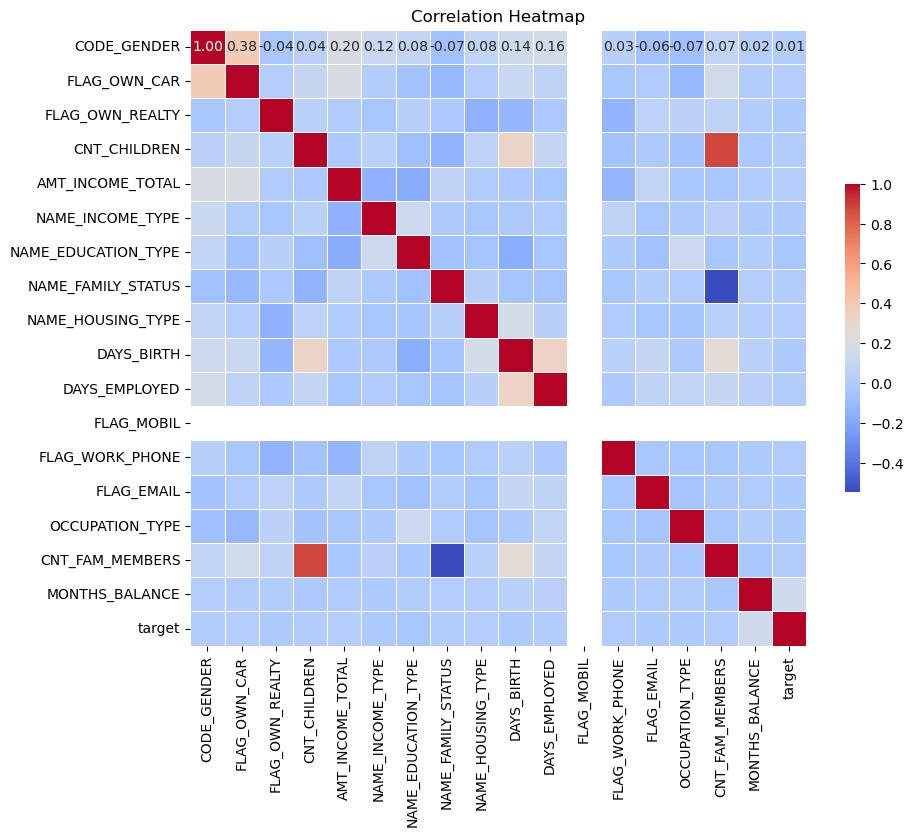

In [11]:
corr = df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

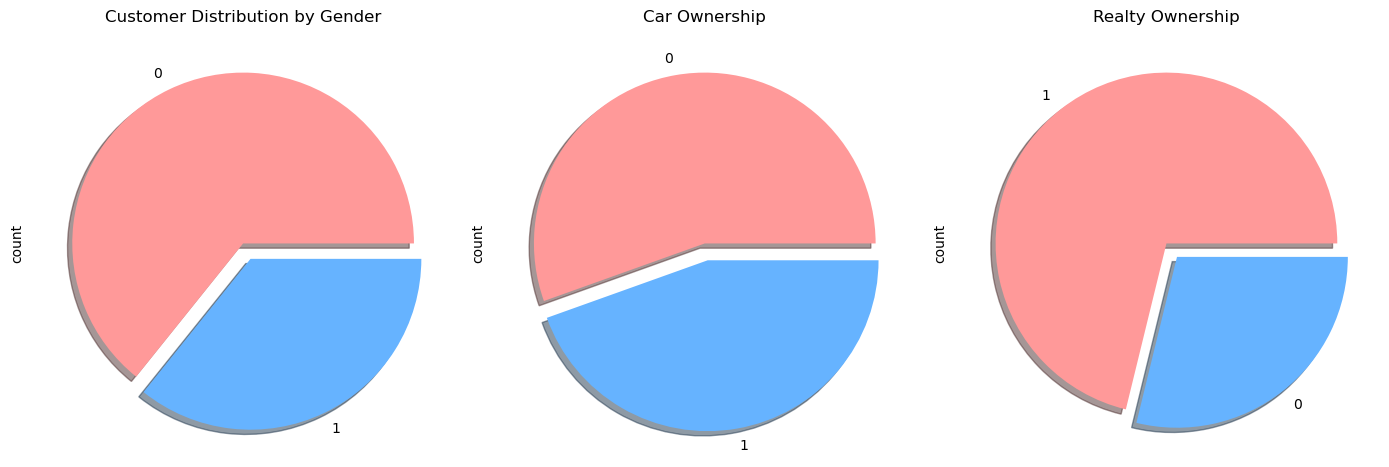

In [12]:
fig, axes = plt.subplots(1,3)
colors = ['#ff9999', '#66b3ff']

g1= df['CODE_GENDER'].value_counts().plot.pie(explode=[0,0.1], ax=axes[0], colors=colors, shadow=True)
g1.set_title("Customer Distribution by Gender")

g2= df['FLAG_OWN_CAR'].value_counts().plot.pie(explode=[0,0.1], ax=axes[1],   colors=colors, shadow=True)
g2.set_title("Car Ownership")

g3= df['FLAG_OWN_REALTY'].value_counts().plot.pie(explode=[0,0.1], ax=axes[2],   colors=colors, shadow=True)
g3.set_title("Realty Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

In [13]:
df["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
4    89226
0    43696
2    15332
3      322
Name: count, dtype: int64

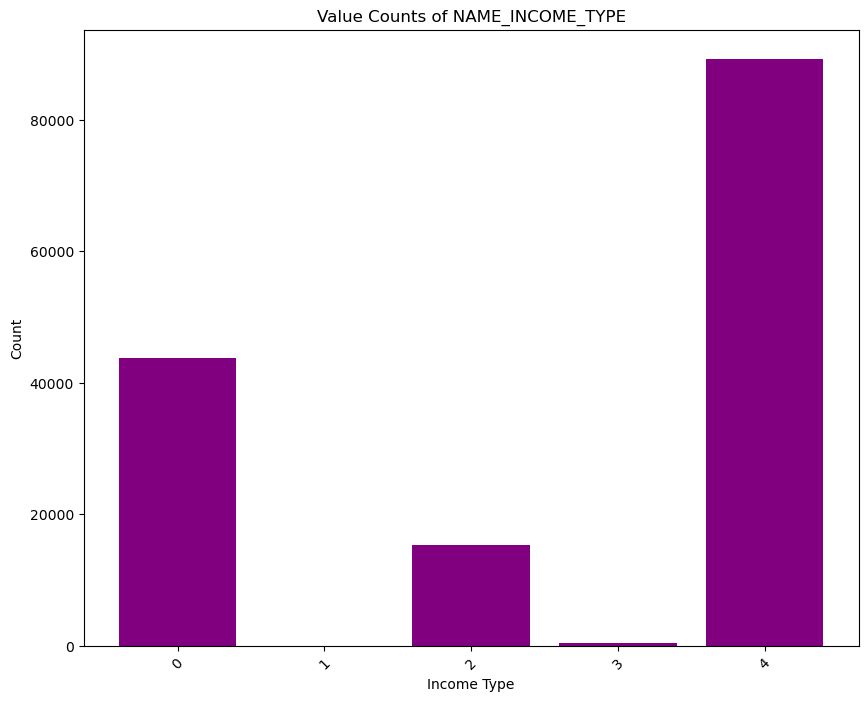

In [14]:
income_type_counts = df["NAME_INCOME_TYPE"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 8))

# Create the bar plot
plt.bar(income_type_counts.index, income_type_counts.values, color='Purple')

# Add labels and title
plt.xlabel("Income Type")
plt.ylabel("Count")
plt.title("Value Counts of NAME_INCOME_TYPE")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)  # Rotate labels to prevent overlap

# Show plot
plt.show()

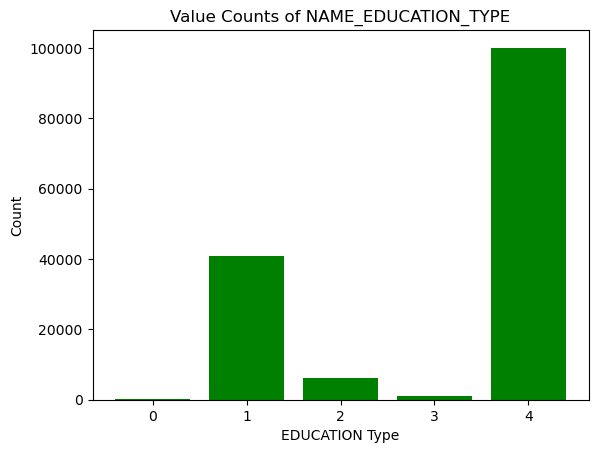

In [15]:
plt.bar(df["NAME_EDUCATION_TYPE"].value_counts().index, df["NAME_EDUCATION_TYPE"].value_counts().values,color='green')
# Add labels and title
plt.xlabel("EDUCATION Type")
plt.ylabel("Count")
plt.title("Value Counts of NAME_EDUCATION_TYPE")

# Rotate x-axis labels for better visibility
plt.xticks()

# Show plot
plt.show()

<Axes: ylabel='NAME_FAMILY_STATUS'>

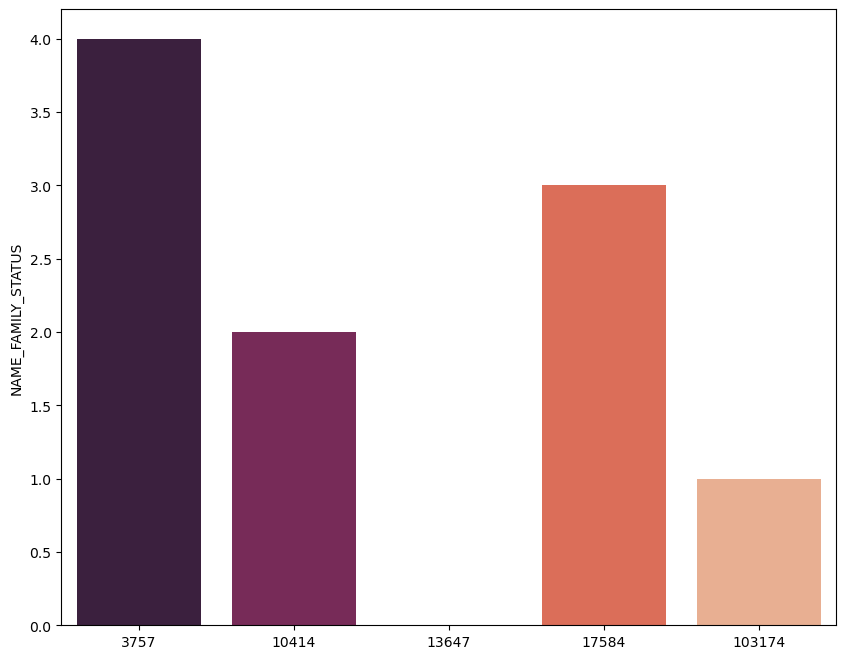

In [17]:
plt.figure(figsize=(10, 8))

sns.barplot(data=df,
            y=df["NAME_FAMILY_STATUS"].value_counts().index,
            x=df["NAME_FAMILY_STATUS"].value_counts().values,
            palette='rocket')

<Axes: ylabel='OCCUPATION_TYPE'>

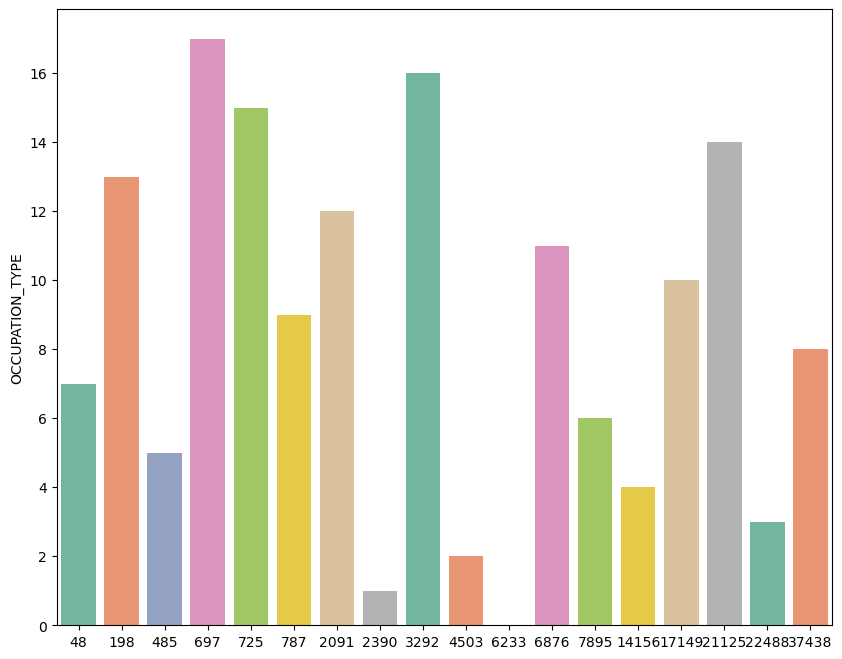

In [18]:
plt.figure(figsize=(10, 8))

sns.barplot(data=df,
            y=df["OCCUPATION_TYPE"].value_counts().index,
            x=df["OCCUPATION_TYPE"].value_counts().values,
            palette='Set2')

<Axes: xlabel='CNT_CHILDREN'>

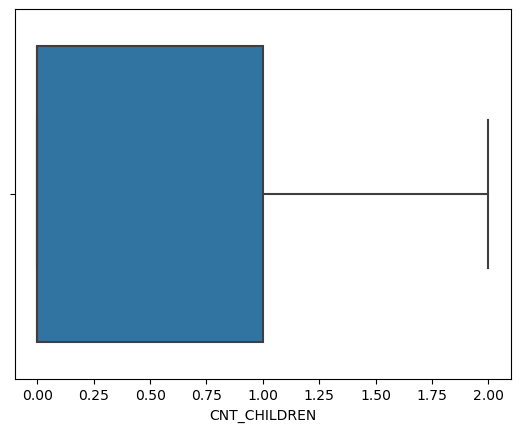

In [19]:
sns.boxplot( x=df["CNT_CHILDREN"])

<Axes: xlabel='CNT_FAM_MEMBERS'>

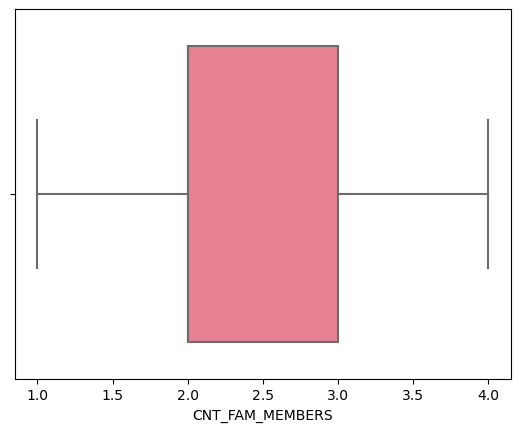

In [20]:
sns.boxplot( x=df["CNT_FAM_MEMBERS"],palette="husl")

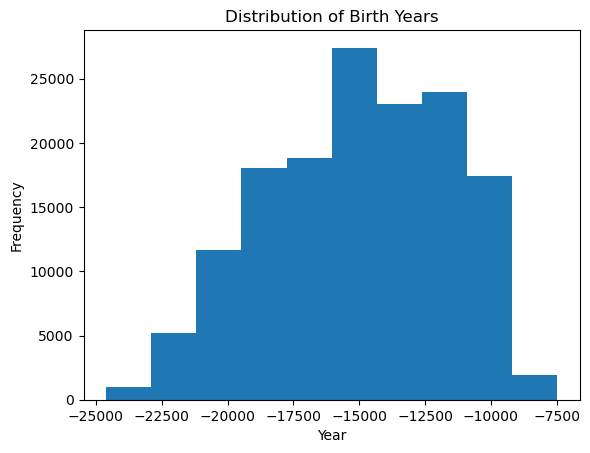

In [21]:
plt.hist(df['DAYS_BIRTH'])
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Birth Years')
plt.show()

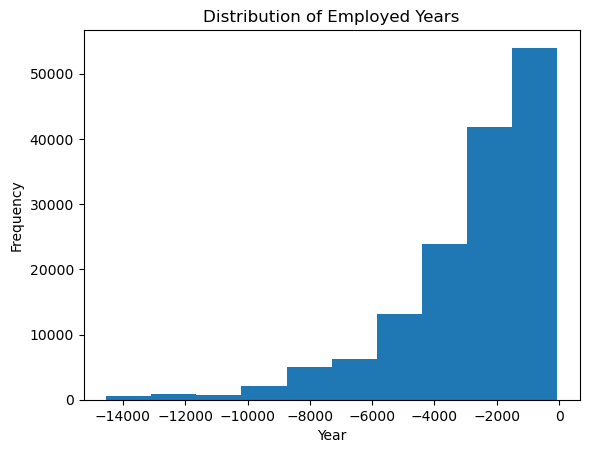

In [22]:
plt.hist(df['DAYS_EMPLOYED'])
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Employed Years')
plt.show()

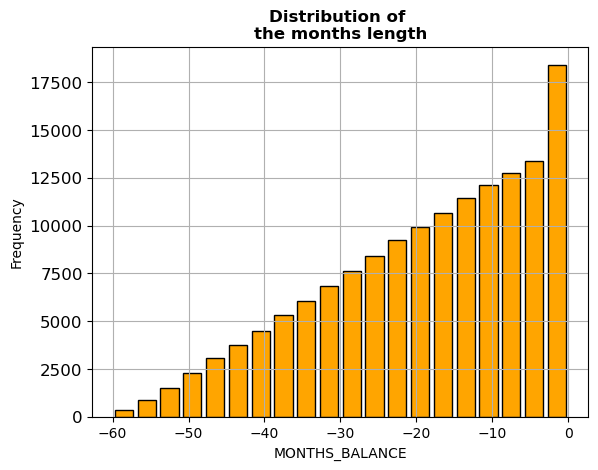

In [23]:
ax = df["MONTHS_BALANCE"].hist( # Remove grid
                        xlabelsize=10, # Change size of labels on the x-axis
                        ylabelsize=12, # Change size of labels on the y-axis
                        bins=20, # Number of bins
                        edgecolor='black', # Color of the border
                        color='orange', # Color of the bins
                        rwidth=0.8 # Space between bins
                       )

# Add a bold title ('\n' allow us to jump rows)
ax.set_title('Distribution of \nthe months length',
             weight='bold') 

# Add label names
ax.set_xlabel('MONTHS_BALANCE')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

### Data Cleaning and Transformation

In [24]:
# Select the columns where you want to remove outliers
columns_to_filter = ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

# Calculate lower and upper bounds for each selected column
lower_bounds = df[columns_to_filter].quantile(0.05)
upper_bounds = df[columns_to_filter].quantile(0.90)

# Define the boundaries for outlier removal
lower_bound_limits = lower_bounds - 0.05 * (upper_bounds - lower_bounds)
upper_bound_limits = upper_bounds + 0.05 * (upper_bounds - lower_bounds)

# Filter out the rows containing outliers in any of the selected columns
df = df[~((df[columns_to_filter] < lower_bound_limits) | (df[columns_to_filter] > upper_bound_limits)).any(axis=1)]

In [25]:
X = df.drop(columns=['target'])
y = df['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Handling class imbalance

#### 1 Random Over Sampler

In [27]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [28]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [29]:
unique_values, counts = np.unique(y_resampled, return_counts=True)
print(unique_values)
print(counts)

[0 1 2 3 4 5 6 7]
[52322 52322 52322 52322 52322 52322 52322 52322]


#### 2 Class weighting

In [30]:
class_distribution = df['target'].value_counts()

# Calculate inverse frequency weights
total_samples = class_distribution.sum()
class_weights = total_samples / (len(class_distribution) * class_distribution)

class_weights = class_weights.to_dict()

print("Class Weights:")
print(class_weights)

Class Weights:
{6: 0.2964790145636635, 0: 0.32927987688388877, 7: 0.6668834099995701, 1: 12.15703369905956, 5: 180.3764534883721, 2: 574.5324074074074, 3: 1410.215909090909, 4: 2585.3958333333335}


#### 3 One-Class Learning

In [31]:
class_label = 0
class_df = df[df['target'] == class_label]

X_class = class_df.drop('target', axis=1)
y_class = class_df['target']

X_train_1c, X_test_1c, y_train_1c, y_test_1c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

unique_values_set = set(y_train_1c)
for value in unique_values_set:
    print(value)

0


### Store cleaned dataset

In [32]:
df_cleaned = pd.DataFrame(X_resampled)

In [33]:
df_cleaned['target'] = y_resampled

In [34]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418576 entries, 0 to 418575
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          418576 non-null  int64  
 1   FLAG_OWN_CAR         418576 non-null  int64  
 2   FLAG_OWN_REALTY      418576 non-null  int64  
 3   CNT_CHILDREN         418576 non-null  int64  
 4   AMT_INCOME_TOTAL     418576 non-null  float64
 5   NAME_INCOME_TYPE     418576 non-null  int64  
 6   NAME_EDUCATION_TYPE  418576 non-null  int64  
 7   NAME_FAMILY_STATUS   418576 non-null  int64  
 8   NAME_HOUSING_TYPE    418576 non-null  int64  
 9   DAYS_BIRTH           418576 non-null  int64  
 10  DAYS_EMPLOYED        418576 non-null  int64  
 11  FLAG_MOBIL           418576 non-null  int64  
 12  FLAG_WORK_PHONE      418576 non-null  int64  
 13  FLAG_EMAIL           418576 non-null  int64  
 14  OCCUPATION_TYPE      418576 non-null  int64  
 15  CNT_FAM_MEMBERS  

In [35]:
# df_cleaned.to_csv('Credit_Record_Cleaned.csv', index=False)

# Model Training

## K-Nearest Neigbours

### with class imbalance

In [36]:
knn_classifier = KNeighborsClassifier()

In [37]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
y_pred1 = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

  File "C:\Users\lenovo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\lenovo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Accuracy: 0.6575745366639807
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      9444
           1       0.27      0.10      0.15       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.28      0.31      0.29        16
           6       0.69      0.73      0.71     10438
           7       0.65      0.49      0.56      4629

    accuracy                           0.66     24820
   macro avg       0.36      0.33      0.34     24820
weighted avg       0.65      0.66      0.65     24820



In [39]:
cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.34033038 0.33964545 0.32018533 0.30958904 0.31012531]
Mean CV Score: 0.3239751017349494


### without class imbalance 1 Random Over Sampler

In [40]:
knn_classifier.fit(X_train_rs, y_train_rs)

KNeighborsClassifier()

In [41]:
y_pred2 = knn_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred2))
print(classification_report(y_test_rs, y_pred2))

Accuracy: 0.8517368245018874
              precision    recall  f1-score   support

           0       0.63      0.61      0.62     10605
           1       0.91      0.99      0.95     10437
           2       0.99      0.96      0.98     10632
           3       0.96      0.91      0.93     10425
           4       0.91      1.00      0.95     10463
           5       1.00      0.99      0.99     10429
           6       0.68      0.65      0.66     10355
           7       0.72      0.70      0.71     10370

    accuracy                           0.85     83716
   macro avg       0.85      0.85      0.85     83716
weighted avg       0.85      0.85      0.85     83716



In [42]:
cv_scores = cross_val_score(knn_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.61445841 0.5823807  0.61824046 0.60624739 0.60834976]
Mean CV Score: 0.6059353414360461


The precesion for the class with low number of samples has increased. Although this accuracy is very good at face value, it might be overfitting the given dataset as KNN is a relatively simple model.

### without class imbalance 2 Class weighting

K-NN cannot use weights to train model as it is a simple model

### without class imbalance 3 One-Class learning

In [43]:
knn_classifier.fit(X_train_1c, y_train_1c)

KNeighborsClassifier()

In [44]:
y_pred1_c = knn_classifier.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred1_c))
print(classification_report(y_test_1c, y_pred1_c))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9422

    accuracy                           1.00      9422
   macro avg       1.00      1.00      1.00      9422
weighted avg       1.00      1.00      1.00      9422



In [45]:
cv_scores = cross_val_score(knn_classifier, X_train_1c, y_train_1c, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [46]:
y_pred1 = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))

Accuracy: 0.38049959709911363


These results indicate that KNN is incapable of learning on one-class datasets, as it seems to be overfitting this model. This can be verified by looking at the model's prediction on multiclass dataset after it has been trained on one-class.

## Logistic Regression

### with class imbalance

In [47]:
lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, y_train)

LogisticRegression()

In [48]:
y_pred5 = lg_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

Accuracy: 0.42054794520547945
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9444
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        16
           6       0.42      1.00      0.59     10438
           7       0.00      0.00      0.00      4629

    accuracy                           0.42     24820
   macro avg       0.06      0.14      0.08     24820
weighted avg       0.18      0.42      0.25     24820



In [49]:
cv_scores = cross_val_score(lg_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.42453666 0.41607575 0.42159549 0.4186946  0.42161247]
Mean CV Score: 0.4205029944599058


### without class imbalance 1 Random Over Sampler

In [50]:
lg_classifier.fit(X_train_rs, y_train_rs)

LogisticRegression()

In [51]:
y_pred6_rs = lg_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred6_rs))
print(classification_report(y_test_rs, y_pred6_rs))

Accuracy: 0.2126953031678532
              precision    recall  f1-score   support

           0       0.22      0.02      0.03     10605
           1       0.17      0.03      0.06     10437
           2       0.24      0.52      0.33     10632
           3       0.00      0.00      0.00     10425
           4       0.30      0.66      0.42     10463
           5       0.21      0.21      0.21     10429
           6       0.23      0.13      0.17     10355
           7       0.09      0.13      0.11     10370

    accuracy                           0.21     83716
   macro avg       0.18      0.21      0.16     83716
weighted avg       0.18      0.21      0.16     83716



In [52]:
cv_scores = cross_val_score(lg_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.20937455 0.21684286 0.21308009 0.20771666 0.2022935 ]
Mean CV Score: 0.2098615316859534


### without class imbalance 2 Class Weighting

In [53]:
lg_classifier2 = LogisticRegression(class_weight=class_weights)
lg_classifier2.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.32927987688388877, 1: 12.15703369905956,
                                 2: 574.5324074074074, 3: 1410.215909090909,
                                 4: 2585.3958333333335, 5: 180.3764534883721,
                                 6: 0.2964790145636635, 7: 0.6668834099995701})

In [54]:
y_pred4 = lg_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.10382755842062852
              precision    recall  f1-score   support

           0       0.37      0.02      0.04      9444
           1       0.01      0.01      0.01       288
           2       0.00      0.67      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.00      0.06      0.00        16
           6       0.42      0.16      0.23     10438
           7       0.23      0.15      0.18      4629

    accuracy                           0.10     24820
   macro avg       0.13      0.13      0.06     24820
weighted avg       0.36      0.10      0.15     24820



In [55]:
cv_scores = cross_val_score(lg_classifier2, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.08066076 0.06796938 0.06285254 0.08654311 0.11152746]
Mean CV Score: 0.08191064889169059


After providing weights the the overall acuuracy of the model has decreased which indicates that providing weights has a negative impact on the models learning ability. This can be varified by looking at the precesion of the minority class.

### without class imbalance 3 One-Class Learning

Logistic regression cannot be applied on one-class datasets as the model is incapable of learning from a single class dataset. Since it takes into account the probability of each class, it cannot determine what would be the probability of the complement class if only one class is provided. This means it would calculate p for one class but for anyother class it would have no data to train on and no probabilities to go off of.

## Naive Bayes

### with class imbalance

In [56]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [57]:
y_pred7 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred7))
print(classification_report(y_test, y_pred7))

Accuracy: 0.4736502820306205
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      9444
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        16
           6       0.47      0.79      0.59     10438
           7       0.00      0.00      0.00      4629

    accuracy                           0.47     24820
   macro avg       0.14      0.17      0.14     24820
weighted avg       0.38      0.47      0.41     24820



In [58]:
cv_scores = cross_val_score(nb_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.47767929 0.45862208 0.46684126 0.46011281 0.4700834 ]
Mean CV Score: 0.46666776860115905


As should be obvious from the name, Naive-Bayes is severely impacted by the imbalance of distirbution of classes. From the classificiation report, the precesion for minority class is unacceptable.

### without class imbalance 1 Random Over Sampler

In [59]:
nb_classifier.fit(X_train_rs, y_train_rs)

GaussianNB()

In [60]:
y_pred8_rs = nb_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred8_rs))
print(classification_report(y_test_rs, y_pred8_rs))

Accuracy: 0.24698982273400544
              precision    recall  f1-score   support

           0       0.34      0.11      0.17     10605
           1       0.23      0.08      0.12     10437
           2       0.23      0.29      0.26     10632
           3       0.31      0.37      0.34     10425
           4       0.24      0.50      0.33     10463
           5       0.23      0.28      0.25     10429
           6       0.21      0.31      0.25     10355
           7       0.33      0.04      0.07     10370

    accuracy                           0.25     83716
   macro avg       0.26      0.25      0.22     83716
weighted avg       0.26      0.25      0.22     83716



In [61]:
cv_scores = cross_val_score(nb_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.23696784 0.24725557 0.25249955 0.24180852 0.24039897]
Mean CV Score: 0.2437860909804846


After handling class imbalance our precesion for minority class has increased and the overall of accuracy is impacted accordingly. But these results are insufficient for a real world model, as the accuracy should be between 80-90%, in training atleast.

### without class imabalnce 2 Class Weighting

In [62]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

# Create replicated samples based on weights
X_weighted = []
y_weighted = []
for label, weight in class_weights.items():
    indices = np.where(y_train_np == label)[0]
    X_label = X_train_np[indices]
    y_label = y_train_np[indices]
    X_weighted.extend([X_label] * int(weight))
    y_weighted.extend([y_label] * int(weight))

X_weighted = np.vstack(X_weighted)
y_weighted = np.hstack(y_weighted)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_weighted, y_weighted, test_size=0.2, random_state=42)

In [63]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_w, y_train_w)

GaussianNB()

In [64]:
y_pred4_w = nb_classifier.predict(X_test_w)
print("Accuracy:", accuracy_score(y_test_w, y_pred4_w))
print(classification_report(y_test_w, y_pred4_w))

Accuracy: 0.40016557537442615
              precision    recall  f1-score   support

           1       0.49      0.32      0.39      2342
           2       0.32      0.34      0.33      2753
           3       0.29      0.11      0.16      2562
           4       0.41      0.83      0.55      3113
           5       0.49      0.30      0.37      2517

    accuracy                           0.40     13287
   macro avg       0.40      0.38      0.36     13287
weighted avg       0.40      0.40      0.37     13287



In [65]:
cv_scores = cross_val_score(nb_classifier, X_weighted, y_weighted, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.39903665 0.40009031 0.4004215  0.39974409 0.4006473 ]
Mean CV Score: 0.3999879703903928


In [66]:
y_pred4 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.0037469782433521355
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9444
           1       0.01      0.31      0.02       288
           2       0.00      0.33      0.00         3
           3       0.00      0.50      0.00         2
           4       0.00      0.00      0.00         0
           5       0.00      0.19      0.00        16
           6       0.00      0.00      0.00     10438
           7       0.00      0.00      0.00      4629

    accuracy                           0.00     24820
   macro avg       0.00      0.17      0.00     24820
weighted avg       0.00      0.00      0.00     24820



Our results for weighted classes for Naive-Bayes algorithm tell us that the model is incapable of learning features if weights are applied to it.

### without class imbalance 1 class learning

In [67]:
nb_classifier.fit(X_train_1c, y_train_1c)

GaussianNB()

In [68]:
y_pred4_1c = nb_classifier.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred4_1c))
print(classification_report(y_test_1c, y_pred4_1c))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9422

    accuracy                           1.00      9422
   macro avg       1.00      1.00      1.00      9422
weighted avg       1.00      1.00      1.00      9422



In [69]:
cv_scores = cross_val_score(nb_classifier, X_class, y_class, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [70]:
y_pred4 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.38049959709911363
              precision    recall  f1-score   support

           0       0.38      1.00      0.55      9444
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00     10438
           7       0.00      0.00      0.00      4629

    accuracy                           0.38     24820
   macro avg       0.05      0.14      0.08     24820
weighted avg       0.14      0.38      0.21     24820



Here the model has learned features for the one class it was trained on but the accuracy is still quite low and insufficient.

## Random Forest

### with class imbalance

In [71]:
rf_classifier = RandomForestClassifier()

In [72]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
y_pred3 = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy: 0.6245769540692989
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      9444
           1       0.25      0.16      0.20       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.19      0.19      0.19        16
           6       0.66      0.71      0.69     10438
           7       0.55      0.51      0.53      4629

    accuracy                           0.62     24820
   macro avg       0.28      0.27      0.28     24820
weighted avg       0.62      0.62      0.62     24820



In [74]:
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.63149678 0.62902901 0.62610798 0.63124496 0.63152858]
Mean CV Score: 0.6298814618108605


### without class imbalance 1 Random Over Sampling

In [75]:
rf_classifier.fit(X_train_rs, y_train_rs)

RandomForestClassifier()

In [76]:
y_pred4_rs = rf_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred4_rs))
print(classification_report(y_test_rs, y_pred4))

Accuracy: 0.8564193224712122
              precision    recall  f1-score   support

           0       0.38      1.00      0.55      9444
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00     10438
           7       0.00      0.00      0.00      4629

    accuracy                           0.38     24820
   macro avg       0.05      0.14      0.08     24820
weighted avg       0.14      0.38      0.21     24820



In [77]:
cv_scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.76755937 0.74998507 0.76772382 0.76201398 0.75605328]
Mean CV Score: 0.7606671025279403


### without class imbalance 2 Class Weighting

In [78]:
rf_classifier2 = RandomForestClassifier(class_weight=class_weights)
rf_classifier2.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.32927987688388877,
                                     1: 12.15703369905956, 2: 574.5324074074074,
                                     3: 1410.215909090909,
                                     4: 2585.3958333333335,
                                     5: 180.3764534883721,
                                     6: 0.2964790145636635,
                                     7: 0.6668834099995701})

In [79]:
y_pred4 = rf_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.6038275584206285
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      9444
           1       0.14      0.25      0.18       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.13      0.25      0.17        16
           6       0.68      0.65      0.66     10438
           7       0.48      0.57      0.52      4629

    accuracy                           0.60     24820
   macro avg       0.26      0.29      0.27     24820
weighted avg       0.61      0.60      0.61     24820



In [80]:
cv_scores = cross_val_score(rf_classifier2, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.61376914 0.61094883 0.60868251 0.61240935 0.60977084]
Mean CV Score: 0.6111161338722662


### 3 One-Class Learning

In [81]:
rf_classifier.fit(X_train_1c, y_train_1c)

RandomForestClassifier()

In [82]:
y_pred4_1c = rf_classifier2.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred4_1c))
print(classification_report(y_test_1c, y_pred4_1c))

Accuracy: 0.7154531946508172
              precision    recall  f1-score   support

           0       1.00      0.72      0.83      9422
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.72      9422
   macro avg       0.14      0.10      0.12      9422
weighted avg       1.00      0.72      0.83      9422



In [83]:
cv_scores = cross_val_score(rf_classifier2, X_train_1c, y_train_1c, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [84]:
y_pred4 = rf_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.6038275584206285
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      9444
           1       0.14      0.25      0.18       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.13      0.25      0.17        16
           6       0.68      0.65      0.66     10438
           7       0.48      0.57      0.52      4629

    accuracy                           0.60     24820
   macro avg       0.26      0.29      0.27     24820
weighted avg       0.61      0.60      0.61     24820



## Xgboost

### with class imbalance

In [85]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [86]:
y_pred9 = xgb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred9))
print(classification_report(y_test, y_pred9))

Accuracy: 0.6804190169218373
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      9444
           1       0.44      0.06      0.10       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.14      0.19      0.16        16
           6       0.68      0.81      0.74     10438
           7       0.71      0.49      0.58      4629

    accuracy                           0.68     24820
   macro avg       0.38      0.31      0.32     24820
weighted avg       0.68      0.68      0.67     24820



In [87]:
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.68634166 0.68196011 0.67722603 0.67974416 0.68204482]
Mean CV Score: 0.6814633566158841


### without class imbalance

In [88]:
xgb_classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [89]:
y_pred10 = xgb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred10))
print(classification_report(y_test, y_pred10))

Accuracy: 0.6412167606768735
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      9444
           1       0.12      0.93      0.21       288
           2       0.11      1.00      0.19         3
           3       0.33      1.00      0.50         2
           4       0.00      0.00      0.00         0
           5       0.35      1.00      0.52        16
           6       0.74      0.69      0.72     10438
           7       0.57      0.70      0.63      4629

    accuracy                           0.64     24820
   macro avg       0.37      0.73      0.42     24820
weighted avg       0.70      0.64      0.66     24820



In [90]:
cv_scores = cross_val_score(xgb_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.73296622 0.7119871  0.72793406 0.72728902 0.74034522]
Mean CV Score: 0.7281043230813615


### without class imbalance 2 Class Weighting

In [91]:
xgb_classifier2 = xgb.XGBClassifier(sample_weight=class_weights)
xgb_classifier2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [92]:
y_pred4 = xgb_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.6804190169218373
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      9444
           1       0.44      0.06      0.10       288
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           5       0.14      0.19      0.16        16
           6       0.68      0.81      0.74     10438
           7       0.71      0.49      0.58      4629

    accuracy                           0.68     24820
   macro avg       0.38      0.31      0.32     24820
weighted avg       0.68      0.68      0.67     24820



In [93]:
cv_scores = cross_val_score(xgb_classifier2, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.68634166 0.68196011 0.67722603 0.67974416 0.68204482]
Mean CV Score: 0.6814633566158841


### without class imbalance 3 One-Class Learning

XGBoost is not suitable for one-class learning as it cannot calculate gradient for only one class

On par with Random Forest, XGBoost produced similar results with or without handling class imbalance. So either of the models should prove accurate in live testing as well for classifiying celestial objects.